In [1]:
import torch.distributions
import torchvision
import numpy as np

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# importando função que mostra imagens no jupyter notebook
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
# Importando bibliotecas usadas na comparação dos algoritmos
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import seaborn as sns
import torch.distributions
import torchvision
import numpy as np
import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid

train_dataset = torchvision.datasets.MNIST('./data', 
                                            transform=torchvision.transforms.ToTensor(), 
                                            train=True,
                                            download=True)

val_dataset = torchvision.datasets.MNIST('./data', 
                                            transform=torchvision.transforms.ToTensor(), 
                                            train=False,
                                            download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

for a in train_loader:
    print(a[0].shape)
    break

torch.Size([128, 1, 28, 28])

class Encoder(nn.Module):
    def __init__(self, latent_dims,input_size):
        input_=np.prod(input_size)
        print(input_)
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(28*28, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # it flattens the image x by transforming it to 1-d tensor
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))        
        x = F.relu(self.linear3(x))

        return self.linear4(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dims,input_size):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, 28*28)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))        
        z = F.relu(self.linear3(z))
        z = torch.sigmoid(self.linear4(z))

        return z.reshape((-1, 1,28,28)) # it transforms the generated tensor into image
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dims,input_size):
        
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims,input_size)
        self.decoder = Decoder(latent_dims,input_size)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)  
    
    
    
def train(model, train_loader, val_loader, epochs=20):
    log_dict = {"train_loss": [],
                "val_loss": [],
                "reconstructed_images":[]}    
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)    
    for epoch in tqdm.tqdm_notebook(range(epochs)):
        train_loss = []
        model.train() # set model to training mode
        for x, y in train_loader:
            x = x.to(device) # GPU
            
            opt.zero_grad()
            x_hat = model(x)
            
            loss = ((x - x_hat)**2).mean() # reconstruction loss
            train_loss.append(loss.to('cpu').detach().numpy())

            loss.backward() # compute gradients            
            opt.step() # update weights     
        val_loss = []
        model.eval() # set model to evaluation mode
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device) # GPU
                x_hat = model(x)
                
                loss = ((x - x_hat)**2).mean() # reconstruction loss
                val_loss.append(loss.to('cpu').detach().numpy())
        
        log_dict["train_loss"].append(np.array(train_loss).mean())
        log_dict["val_loss"].append(np.array(val_loss).mean())
        log_dict["reconstructed_images"].append(x_hat.to('cpu').detach()[:5])
    log_dict["original_images"] = x.to('cpu').detach()[:5]

    return model, log_dict    
   
latent_dims = 16
input_size=[1, 28, 28]
py_autoencoder = Autoencoder(latent_dims,input_size).to(device) # GPU
py_autoencoder, log_dict = train(py_autoencoder, train_loader, val_loader, epochs=50)





100%|██████████| 9912422/9912422 [00:00<00:00, 104684632.70it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 116364739.50it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41894180.98it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22203413.48it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([128, 1, 28, 28])
784


  0%|          | 0/50 [00:00<?, ?it/s]

In [2]:
def plot_loss(history):
    """
    Plot loss history
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(history['train_loss'], color='#407cdb', label='Train')
    ax.plot(history['val_loss'],color='#db5740', label='Validation')
    
    ax.legend(loc='upper left')
    handles, labels = ax.get_legend_handles_labels()  
    lgd = dict(zip(labels, handles))
    ax.legend(lgd.values(), lgd.keys())
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Pytorch Loss over the epochs, latent_dims: %s'%latent_dims)
    plt.show()

#


def plot_reconstructed(log_dict, step=5):
    reconstructed_images = log_dict["reconstructed_images"]
    original_images = log_dict["original_images"]

    epochs = len(reconstructed_images)
    
    fig = plt.figure(figsize=(10,10))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(5, epochs//step + 1),
                    axes_pad=0.05)
    grid = iter(grid)
    for i in range(5):
        img = original_images[i]    
        img = img.numpy().reshape((28,28))
        ax = next(grid)
        ax.imshow(img)
        ax.set_axis_off() 

        for j in range(epochs//step):
            img = reconstructed_images[j*step][i]
            img = img.numpy().reshape((28,28))
            ax = next(grid)
            ax.imshow(img)
            ax.set_axis_off()    

    plt.show()


def plot_umap_latent(autoencoder, dataloader, num_batches=100):
    from sklearn.decomposition import PCA
    import umap
    latent_space = []
    labels = []
    for i, (x, y) in enumerate(dataloader):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        latent_space.append(z)
        labels.append(y)

        if i > num_batches:            
            break
    
    latent_space = np.concatenate(latent_space)
    labels = np.concatenate(labels)

    dim_reducer = umap.UMAP(n_components=2)
    latent_space_reduced = dim_reducer.fit_transform(latent_space)
    
    plt.scatter(latent_space_reduced[:, 0], latent_space_reduced[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    
  


In [3]:
print(py_autoencoder)


Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=128, bias=True)
    (linear4): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=512, bias=True)
    (linear4): Linear(in_features=512, out_features=784, bias=True)
  )
)


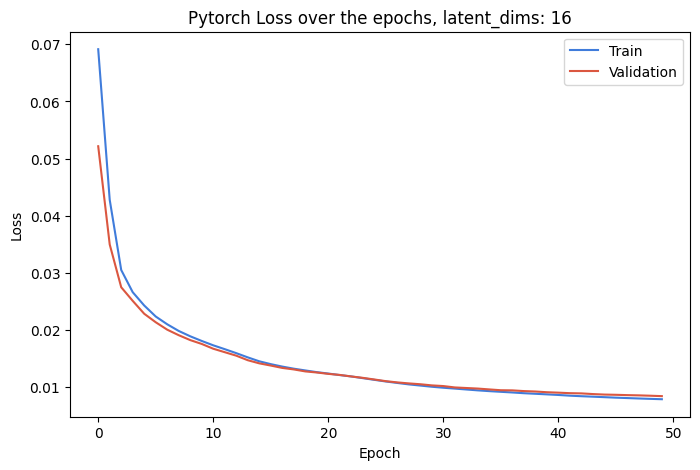

In [4]:
plot_loss(log_dict)

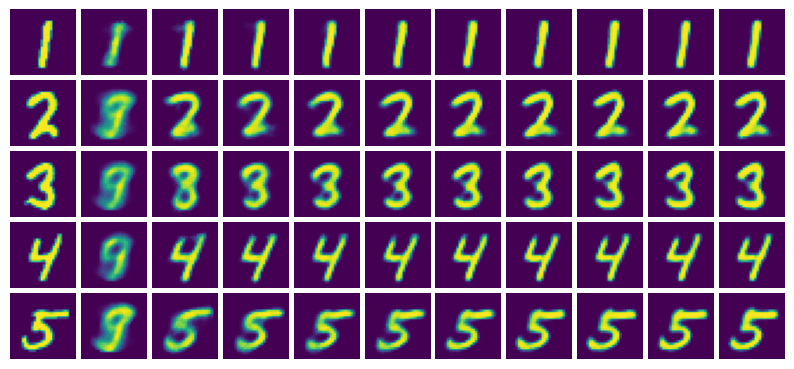

In [5]:
plot_reconstructed(log_dict)

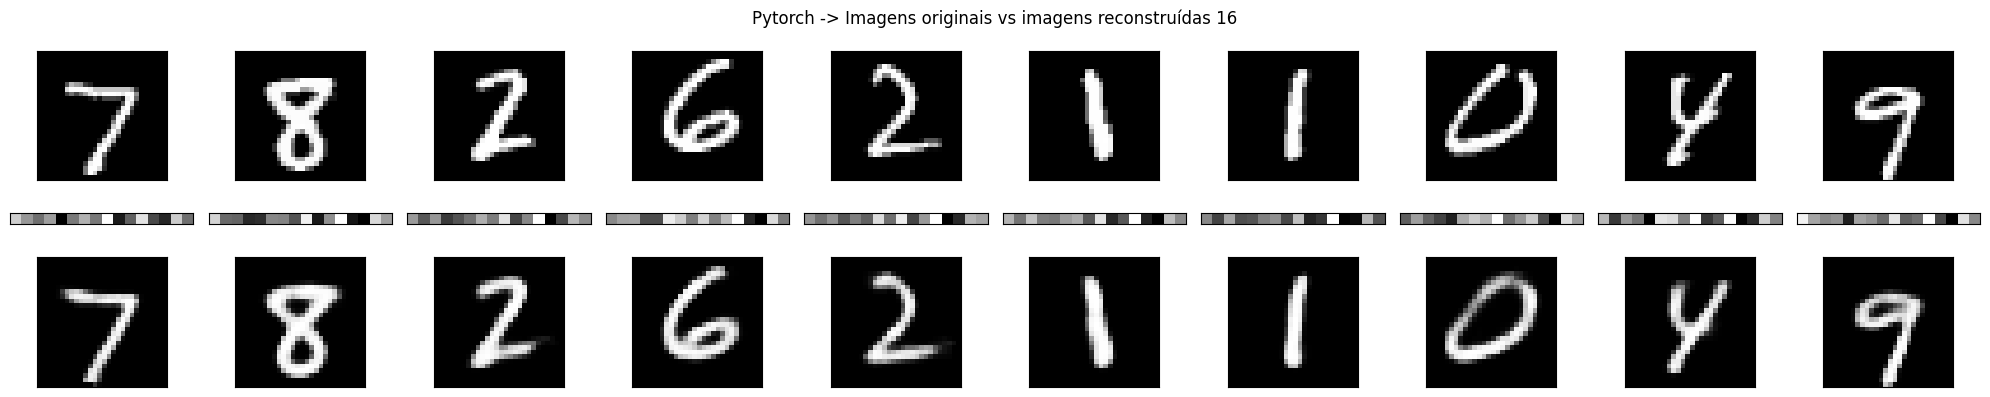

In [6]:
n = 10  # número de exemplos a serem mostrados
plt.figure(figsize=(20, 4))

with torch.no_grad():
    i = 0
    for x, y in val_loader:
        x = x[0].to(device) # GPU
        image = x

        # Imagem original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image.cpu().numpy().reshape((28,28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Imagem reconstruída
        enc_v = py_autoencoder.encoder(image)
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(enc_v.cpu().detach().numpy().reshape(1, -1)) 
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)       

        decresult = py_autoencoder.decoder(enc_v)
        ax = plt.subplot(3, n, i + n*2 + 1)
        plt.imshow(decresult.cpu().detach().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        i += 1
        if i >= n:
            break

plt.suptitle('Pytorch -> Imagens originais vs imagens reconstruídas %s'%latent_dims)
plt.tight_layout()
plt.show()

In [7]:

from torch.utils.mobile_optimizer import optimize_for_mobile
py_autoencoder_cpu=py_autoencoder.to('cpu')
model_enc=py_autoencoder.encoder
example_enc = torch.rand(1, 1, 28, 28)
traced_script_module_enc = torch.jit.trace(model_enc,example_enc)
traced_script_module_optimized_enc = optimize_for_mobile(traced_script_module_enc)
traced_script_module_optimized_enc._save_for_lite_interpreter("model_pytorch_encoder_%s.ptl"%latent_dims)



In [8]:
from torch.utils.mobile_optimizer import optimize_for_mobile
py_autoencoder_cpu=py_autoencoder.to('cpu')
model1=py_autoencoder.decoder
example = torch.rand(1, latent_dims)
traced_script_module = torch.jit.trace(model1,example)
traced_script_module_optimized = optimize_for_mobile(traced_script_module)
traced_script_module_optimized._save_for_lite_interpreter("model_pytorch_decoder_%s.ptl"%latent_dims)

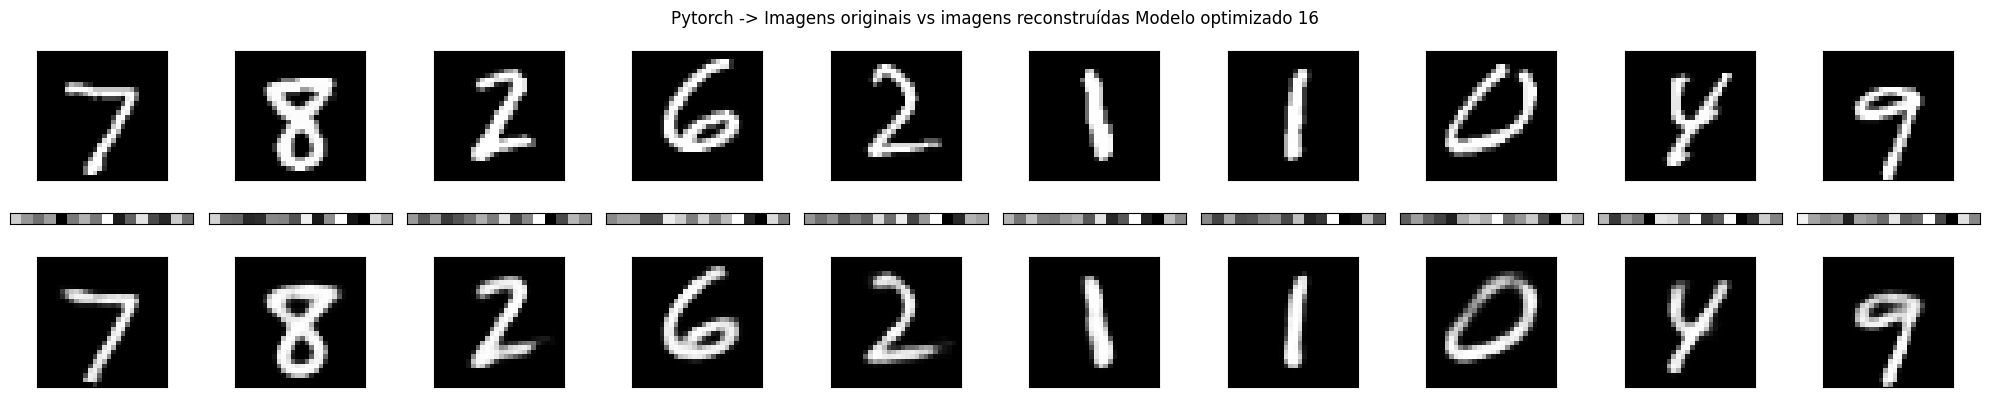

In [9]:
model_encd = torch.jit.load('model_pytorch_encoder_%s.ptl'%latent_dims)
model_encd.eval()

model_dec = torch.jit.load('model_pytorch_decoder_%s.ptl'%latent_dims)
model_dec.eval()
n = 10  # número de exemplos a serem mostrados
plt.figure(figsize=(20, 4))

with torch.no_grad():
    i = 0
    for x, y in val_loader:
        x = x[0].to(device) # GPU
        image = x

        # Imagem original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image.cpu().numpy().reshape((28,28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Imagem reconstruída
        enc_v = model_encd(image.cpu())
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(enc_v.cpu().detach().numpy().reshape(1, -1)) 
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)       

        decresult = model_dec(enc_v)
        ax = plt.subplot(3, n, i + n*2 + 1)
        plt.imshow(decresult.cpu().detach().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        i += 1
        if i >= n:
            break

plt.suptitle('Pytorch -> Imagens originais vs imagens reconstruídas Modelo optimizado %s'%latent_dims)
plt.tight_layout()
plt.show()

torch.Size([1, 28, 28])
tensor([[  2.6323,  -1.2214,   1.1486, -10.9507,  -5.0729,   1.3540,  -2.8625,
           1.6915,  10.7934, -13.5326,  -3.9503,   6.4333,  -9.2127, -10.6168,
           2.9516,  -2.7943]])


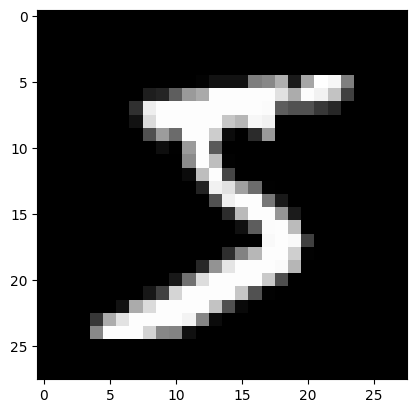

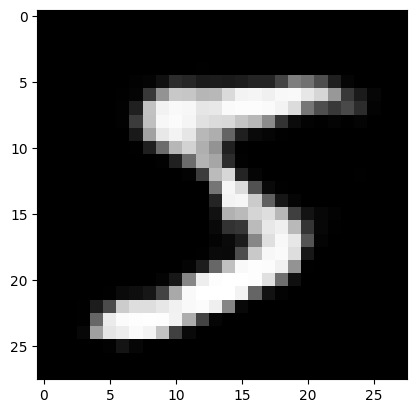

In [10]:



for a in train_dataset:
  print(a[0].shape)

  plt.imshow(a[0].numpy().reshape((28,28)))
  enc_v=model_encd(a[0])
  print(enc_v)
  decesult =py_autoencoder_cpu.decoder(enc_v)
  plt.figure()
  img = decesult.detach().numpy().reshape((28,28))
  plt.imshow(img)
  break

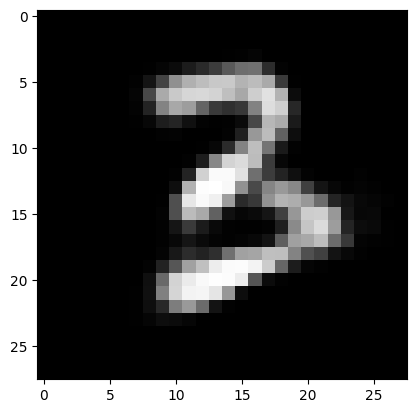

In [11]:
input =[[0.20130968, -1.8826811, 2.8341856, -8.6268215, -6.615596, -3.584663, -0.974563, -1.7944669, 5.489558, -3.713121, -5.8105373, 7.1489453, -9.997446, -10.064896, 0.66726977, 1.0197642]]
data=torch.tensor(input)
result =py_autoencoder_cpu.decoder(data)
img = result.detach().numpy().reshape((28,28))
plt.imshow(img)